In [94]:
import functools
import operator
import subprocess

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from dataproc.data import to_svmrank, scale_features, to_trec

def load_results(basename, buckets=1):
    return pd.concat([
        pq.read_table(f'{basename}#{shard}.results-{buckets}').to_pandas()
        for shard in range(123)
    ])

In [52]:
feature_dir = '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq'

In [53]:
exhaustive_results = pq.read_table(f'{feature_dir}/mq.10k.clean.or.results',
                                   columns=['query', 'rank', 'gdocid', 'score']).to_pandas()

In [54]:
shard_results = load_results(f'{feature_dir}/mq.10k.clean.or')
titles = pd.read_csv('/mnt/moa/index/dai/full/cw09b.titles', names=['title'])
titles.index.name = 'gdocid'
titles.reset_index(inplace=True)
shard_results = pd.merge(shard_results, titles, on='gdocid')
shard_results['query'] += 1
shard_results = shard_results[['query', 'shard', 'rank', 'score', 'title']].sort_values(['query', 'shard'])

# Ground Truth

## FAST

In [55]:
ground_truths = []
for shard in range(123):
    shard_results = pq.read_table(f'{feature_dir}/mq.10k.clean.or#{shard}.results-1',
                                 columns=['query', 'gdocid']).to_pandas()
    ground_truths.append(pd.merge(shard_results, exhaustive_results, on=['query', 'gdocid'], how='left')
                         .groupby('query')['rank']
                         .count()
                         .reset_index()
                         .assign(shard=shard))
    del shard_results
gt = pd.concat(ground_truths).rename(columns={'rank': 'shard_score'}).sort_values(['query', 'shard'])
gt['rank'] = gt.groupby(['query']).rank(method='first', ascending=False)['shard_score']
gt = gt.astype({'rank': np.int})
gt.to_csv(f'{feature_dir}/ground_truth.csv', index=False)
del ground_truths

In [4]:
gt = pd.read_csv(f'{feature_dir}/ground_truth.csv')

## B = 10

In [99]:
ground_truths = []
for shard in range(123):
    shard_results = pq.read_table(f'{feature_dir}/mq.10k.clean.or#{shard}.results-10',
                                 columns=['query', 'bucket', 'gdocid']).to_pandas()
    ground_truths.append(pd.merge(shard_results, exhaustive_results, on=['query', 'gdocid'], how='left')
                         .groupby(['query', 'bucket'])['rank']
                         .count()
                         .reset_index()
                         .assign(shard=shard))
    del shard_results
gt_b10 = pd.concat(ground_truths).rename(columns={'rank': 'shard_score'}).sort_values(['query', 'shard', 'bucket'])
gt_b10['rank'] = gt_b10.groupby(['query']).rank(method='first', ascending=False)['shard_score']
gt_b10 = gt_b10.astype({'rank': np.int})
gt_b10.to_csv(f'{feature_dir}/ground_truth_b10.csv', index=False)
del ground_truths

In [100]:
gt_b10.groupby('bucket').mean()

,query,shard_score,shard,rank
bucket,,,,
0,4997.163639,0.168051,60.985967,584.835633
1,4997.699947,0.090439,60.966226,595.651787
2,4998.703202,0.060158,60.965716,599.510520
3,4998.689790,0.039580,60.863846,604.145185
4,4998.871128,0.024616,60.952825,608.292556
5,4999.824075,0.011336,60.941121,612.897846
6,4999.530790,0.007028,60.945644,614.494820
7,4999.705895,0.005828,60.929626,614.859951
8,4999.281596,0.005336,60.938356,617.132443


# Shard Popularity

In [56]:
clustering_strategy = pd.read_csv(f'{feature_dir}/strategy.csv')

In [57]:
shard_popularity = (pd.merge(exhaustive_results, clustering_strategy, on='gdocid')
                    .groupby('shard')['gdocid']
                    .agg([('popularity', 'count')])
                    .reset_index())
shard_popularity.to_csv(f'{feature_dir}/shard_popularity.csv', index=False)

# Term-Based Statistics

In [58]:
def calc_taily_features(taily_scores):
    tf = taily_scores.copy()
    tf['rank'] = tf.groupby('query').rank(method='first', ascending=False)['taily']
    tf['invrank'] = 1 / tf['rank']
    tf['binrank'] = np.ceil(tf['rank'] / 10)
    return tf

taily = pq.read_table(f'{feature_dir}/mq.10k.clean.or.taily').to_pandas()
taily_features = calc_taily_features(taily)
taily_features.to_csv(f'{feature_dir}/taily_features.csv', index=False)

In [59]:
champion_lists = pd.read_csv(f'{feature_dir}/champion-lists.csv')

ql_body = pd.read_csv(f'{feature_dir}/query-likelihood.text.csv')
ql_title = pd.read_csv(f'{feature_dir}/query-likelihood.title.csv')
ql_anchor = pd.read_csv(f'{feature_dir}/query-likelihood.anchor.csv')
ql = pd.merge(ql_body, ql_title, on=['query', 'shard'], suffixes=['', '-title'])
ql = pd.merge(ql, ql_anchor, on=['query', 'shard'], suffixes=['-body', '-anchor'])
del ql_body
del ql_title
del ql_anchor

In [60]:
qts_body = pd.read_csv(f'{feature_dir}/query-term-stats.text.csv')
qts_title = pd.read_csv(f'{feature_dir}/query-term-stats.title.csv')
qts_anchor = pd.read_csv(f'{feature_dir}/query-term-stats.anchor.csv')
qts = pd.merge(qts_body, qts_title, on=['query', 'shard'], suffixes=['', '-title'])
qts = pd.merge(qts, qts_anchor, on=['query', 'shard'], suffixes=['-body', '-anchor'])
del qts_body
del qts_title
del qts_anchor

In [61]:
bilogfq = pd.read_csv(f'{feature_dir}/bigram-log-frequency.text.csv')

# Cost Models

In [54]:
shard_size_costs = pd.read_csv('/data/index/dai/shard-sizes.csv')
shard_size_costs['cost'] = shard_size_costs['shard_size'] * 100 / shard_size_costs['shard_size'].sum()
shard_size_costs.drop(columns=['shard_size']).to_csv(f'{feature_dir}/shard-size-costs.csv', index=False)

In [101]:
posting_costs = []
for shard in range(123):
    shard_costs = pq.read_table(f'{feature_dir}/mq.10k.clean.or#{shard}.postingcost-1',
                                columns=['query', 'shard', 'postingcost']).to_pandas()
    posting_costs.append(shard_costs)
    del shard_costs
posting_costs = pd.concat(posting_costs).sort_values(['query', 'shard'])

posting_costs_b10 = []
for shard in range(123):
    shard_costs = pq.read_table(f'{feature_dir}/mq.10k.clean.or#{shard}.postingcost-10',
                                columns=['query', 'shard', 'postingcost']).to_pandas()
    posting_costs_b10.append(shard_costs)
    del shard_costs
posting_costs_b10 = pd.concat(posting_costs_b10).sort_values(['query', 'shard'])

In [63]:
sc = pd.merge(gt, posting_costs).sort_values(['query', 'rank'])

In [64]:
with open(f'{feature_dir}/mq.10k.clean.or.rankcost', 'w') as f:
    for query, group in sc.groupby('query'):
        for _, row in group.iterrows():
            print(row.shard, row.postingcost, file=f)
        print(file=f)

# Train

### FAST

In [66]:
df = gt[['query', 'shard', 'shard_score']]
df = pd.merge(df, shard_popularity[['shard', 'popularity']])
df = pd.merge(df, taily_features[['query', 'shard', 'taily', 'invrank', 'binrank']])
df = pd.merge(df, champion_lists)
df = pd.merge(df, ql)
df = pd.merge(df, qts)
df = pd.merge(df, bilogfq)
df['query'] += 1
df, scaler = scale_features(df, exclude=['query', 'shard', 'shard_score'],
                            scaler=StandardScaler())
to_svmrank(df.sort_values(['query', 'shard']), f'{feature_dir}/fast.features.svmrank')

def run_subprocess(cmd):
    return subprocess.run(cmd.split())

model_path = f'{feature_dir}/fast.features.model'
run_subprocess(f'svm_rank_learn -c 1 -t 0 {feature_dir}/fast.features.svmrank {model_path}')

CompletedProcess(args=['svm_rank_learn', '-c', '1', '-t', '0', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/fast.features.svmrank', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/fast.features.model'], returncode=0)

### B=10

In [102]:
df = gt_b10[['query', 'shard', 'bucket', 'shard_score']]
df = pd.merge(df, shard_popularity[['shard', 'popularity']])
df = pd.merge(df, taily_features[['query', 'shard', 'taily', 'invrank', 'binrank']])
df = pd.merge(df, champion_lists)
df = pd.merge(df, ql)
df = pd.merge(df, qts)
df = pd.merge(df, bilogfq)
df['query'] += 1
df, scaler_b10 = scale_features(df, exclude=['query', 'shard', 'bucket', 'shard_score'],
                            scaler=StandardScaler())
to_svmrank(df.sort_values(['query', 'shard', 'bucket']), f'{feature_dir}/b10.features.svmrank')

def run_subprocess(cmd):
    return subprocess.run(cmd.split())

model_path = f'{feature_dir}/b10.features.model'
run_subprocess(f'svm_rank_learn -c 1 -t 0 {feature_dir}/b10.features.svmrank {model_path}')

CompletedProcess(args=['svm_rank_learn', '-c', '1', '-t', '0', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/b10.features.svmrank', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/b10.features.model'], returncode=0)

# Predict

### FAST

In [67]:
eval_features = pd.read_csv('/mnt/moa/michal/experiments/oss/cw09b-dai/features/trec/fast.features.csv')
del eval_features['shard_score']
eval_features, scaler = scale_features(eval_features, exclude=['query', 'shard'], scaler=scaler)
eval_features['shard_score'] = 0
to_svmrank(eval_features.sort_values(['query', 'shard']), f'{feature_dir}/fast.eval.svmrank')
run_subprocess(f'svm_rank_classify {feature_dir}/fast.eval.svmrank {model_path} fast.eval.predict')

CompletedProcess(args=['svm_rank_classify', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/fast.eval.svmrank', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/fast.features.model', 'fast.eval.predict'], returncode=0)

### B=10

In [103]:
eval_features = pd.read_csv('/mnt/moa/michal/experiments/oss/cw09b-dai/features/trec/b10.features.csv')
del eval_features['shard_score']
eval_features, _ = scale_features(eval_features, exclude=['query', 'shard', 'bucket'], scaler=scaler_b10)
eval_features['shard_score'] = 0
to_svmrank(eval_features.sort_values(['query', 'shard', 'bucket']), f'{feature_dir}/b10.eval.svmrank')
run_subprocess(f'svm_rank_classify {feature_dir}/b10.eval.svmrank {model_path} b10.eval.predict')

CompletedProcess(args=['svm_rank_classify', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/b10.eval.svmrank', '/mnt/moa/michal/experiments/oss/cw09b-dai/features/train-mq/b10.features.model', 'b10.eval.predict'], returncode=0)

# Evaluate

In [104]:
from dataproc.selectivesearch import select, load_shard_selection, load_bucket_selection

shard_results = pq.read_table(f'{feature_dir}/../trec/shard_results.parquet').to_pandas()
shard_results = pq.read_table(f'{feature_dir}/../trec/shard_results_b10.parquet').to_pandas()

In [95]:
sel = load_shard_selection(list(range(1, 201)), 123, 'fast.eval.predict')
sel['cost'] = 1

In [96]:
import re

fast_p10 = []
cutoffs = list(range(1, 17)) + [123]
for K in cutoffs:
    filt, selected = select(sel, shard_results, K)
    to_trec(selected, 'trec.in')
    out = subprocess.run(
        f'trec_eval -m all_trec -q /mnt/moa/queries/clueweb/cw09b-qrels.txt trec.in'.split(' '),
        stdout=subprocess.PIPE)
    for line in out.stdout.decode('UTF-8').splitlines():
        p10_re = re.compile(r'P_10\s+all\s+(?P<score>[0-9]+\.[0-9]+).*')
        p10_match = p10_re.match(line)
        if p10_match:
            p10 = float(p10_match.group('score'))
    print(p10)
    fast_p10.append(p10)

0.2838
0.3131
0.3197
0.3273
0.3227
0.3253
0.3253
0.3258
0.3258
0.3293
0.3308
0.3303
0.3298
0.3328
0.3323
0.3308
0.3222


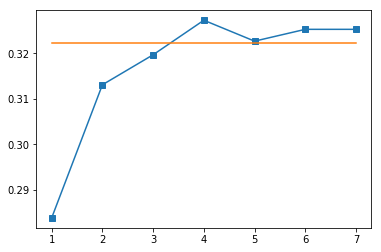

In [98]:
plt.plot(cutoffs[:7], fast_p10[:7], 's-')
plt.plot([1, 7], fast_p10[-1:] * 2)
plt.show()